# 1. Imports and Function Definitions

In [1]:
# Importing all necessary libraries
import tensorflow as tf
from tensorflow.keras.models import clone_model, load_model, Model
from tensorflow.keras.layers import deserialize, Lambda, Conv2D, BatchNormalization, Activation, Concatenate
import numpy as np
from PIL import Image, ImageDraw, ImageOps
import matplotlib.pyplot as plt
import pandas as pd
import yaml
from scipy.special import expit


def compute_iou(box1, box2):
    
    """
    Compute the Intersection over Union (IoU) of two 2D bounding boxes.

    Parameters
    ----------
    box1 : 
        Coordinates of the first box as [x1, y1, x2, y2], where
        (x1, y1) is top-left and (x2, y2) is bottom-right corner.
    box2 : 
        Coordinates of the second box in the same format as `box1`.

    Returns
    -------
    float
        The IoU score, a value in [0, 1], where 0 means no overlap
        and 1 means perfect overlap.
    """
    
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Compute the area of the intersection rectangle
    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)
    
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    union_area = box1_area + box2_area - intersection_area
    iou = intersection_area / union_area if union_area > 0 else 0
    return iou

def non_max_suppression(boxes, scores, iou_threshold=0.4):
    
    """
    Perform non-maximum suppression to filter overlapping boxes.

    Parameters
    ----------
    boxes : np.ndarray, shape (N, 4)
        Array of N boxes, each box = [x1, y1, x2, y2].
    scores : np.ndarray, shape (N,)
        Confidence scores for each box.
    iou_threshold : float, optional
        IoU threshold for suppression. Boxes with IoU > threshold
        are discarded. Default is 0.5.

    Returns
    -------
    List[int]
        Indices of boxes to keep after suppression, sorted by score.
    """
    
    sorted_indices = np.argsort(scores)[::-1]
    keep = []
    
    while len(sorted_indices) > 0:
        current_idx = sorted_indices[0]
        keep.append(current_idx)
        
        remaining_indices = sorted_indices[1:]
        filtered_indices = []
        
        for idx in remaining_indices:
            iou = compute_iou(boxes[current_idx], boxes[idx])
            if iou <= iou_threshold:
                filtered_indices.append(idx)
        
        sorted_indices = np.array(filtered_indices)
    
    return keep

# 2. Loading a model to be the main model

In [4]:
# — load class names
cfg = yaml.safe_load(open('models/YOLO_x_nano/st_yolo_x_nano_192_0.33_0.25_config.yaml'))
class_names = cfg['dataset']['class_names']

# - load model
modelPath = 'models/experimental/greyscale/st_yolo_x_nano_192_0.33_0.25_greyscale.h5'
model = tf.keras.models.load_model(modelPath)
print("expects:", model.input_shape, model.input.dtype)
model.summary()
modelbackup = model

# - view all model layers
# for i, layer in enumerate(model.layers):
#     print(f"{i}: {layer.name} - output shape: {layer.output_shape}")

expects: (None, 192, 192, 1) <dtype: 'float32'>
Model: "st_yolo_x"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_edge (InputLayer)        [(None, 192, 192, 1  0           []                               
                                )]                                                                
                                                                                                  
 st_conv (Conv2D)               (None, 96, 96, 12)   108         ['input_edge[0][0]']             
                                                                                                  
 st_bn (BatchNormalization)     (None, 96, 96, 12)   48          ['st_conv[0][0]']                
                                                                                                  
 st_relu6 (Activation)          (None, 96,

In [18]:
interpreter = tf.lite.Interpreter(model_path="int32.tflite")
interpreter.allocate_tensors()
tensor_details = interpreter.get_tensor_details()
for idx, detail in enumerate(tensor_details):
    print(f"Index {idx}: dtype={detail['dtype']}")
model = tf.keras.models.load_model("models/best_yolo_gs_CP_lComb_nohead1_noCls.h5")
weights = model.layers[1].get_weights()
print(weights[0].dtype)

Index 0: dtype=<class 'numpy.uint8'>
Index 1: dtype=<class 'numpy.int32'>
Index 2: dtype=<class 'numpy.int32'>
Index 3: dtype=<class 'numpy.int8'>
Index 4: dtype=<class 'numpy.int32'>
Index 5: dtype=<class 'numpy.int8'>
Index 6: dtype=<class 'numpy.int32'>
Index 7: dtype=<class 'numpy.int8'>
Index 8: dtype=<class 'numpy.int32'>
Index 9: dtype=<class 'numpy.int8'>
Index 10: dtype=<class 'numpy.int32'>
Index 11: dtype=<class 'numpy.int8'>
Index 12: dtype=<class 'numpy.int32'>
Index 13: dtype=<class 'numpy.int8'>
Index 14: dtype=<class 'numpy.int32'>
Index 15: dtype=<class 'numpy.int8'>
Index 16: dtype=<class 'numpy.int32'>
Index 17: dtype=<class 'numpy.int8'>
Index 18: dtype=<class 'numpy.int32'>
Index 19: dtype=<class 'numpy.int8'>
Index 20: dtype=<class 'numpy.int32'>
Index 21: dtype=<class 'numpy.int8'>
Index 22: dtype=<class 'numpy.int32'>
Index 23: dtype=<class 'numpy.int8'>
Index 24: dtype=<class 'numpy.int32'>
Index 25: dtype=<class 'numpy.int8'>
Index 26: dtype=<class 'numpy.int3

# 3. Any adjustments that need to be made to the model

## a. Turns the model into greyscale

In [19]:
# 1) Create a NEW input with 1 channel
inp_edge = tf.keras.layers.Input(shape=(192, 192, 1), name="input_edge")
# 2) Clone the whole old model, but feed it that new input tensor
new = tf.keras.models.clone_model(modelbackup, input_tensors=inp_edge)

# 3) Load all weights *by name*, skipping any that don’t match shape
new.load_weights(modelPath, by_name=True, skip_mismatch=True)

# 4) Manually collapse & set the first-conv weights
kernel_rgb, *maybe_bias = modelbackup.get_layer("st_conv").get_weights()
# Convert RGB kernel to grayscale using the standard formula
kernel_gray = 299/1000 * kernel_rgb[:, :, 0, :] + 587/1000 * kernel_rgb[:, :, 1, :] + 114/1000 * kernel_rgb[:, :, 2, :]
kernel_gray = np.expand_dims(kernel_gray, axis=2)

# Set the new weights for the first convolution layer
weights = [kernel_gray] + maybe_bias
new.get_layer("st_conv").set_weights(weights)

# 5) Save the new model
print(new.get_layer("st_conv").input)
new.summary()
# new.save('st_yolo_x_nano_192_0.33_0.25_greyscale.h5')
# print("Model saved")

KerasTensor(type_spec=TensorSpec(shape=(None, 192, 192, 1), dtype=tf.float32, name='input_edge'), name='input_edge', description="created by layer 'input_edge'")
Model: "st_yolo_x"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_edge (InputLayer)        [(None, 192, 192, 1  0           []                               
                                )]                                                                
                                                                                                  
 st_conv (Conv2D)               (None, 96, 96, 12)   108         ['input_edge[0][0]']             
                                                                                                  
 st_bn (BatchNormalization)     (None, 96, 96, 12)   48          ['st_conv[0][0]']                
                           

## b. Combines layers and gets rid of excess

In [3]:
# Define which model to use for next steps
orig = modelbackup

bypass_start, bypass_end = 1, 9  # layers to bypass
# bypass layers 5–10 by name
to_skip = [L.name for L in orig.layers[bypass_start:bypass_end+1]]

#configs for the new fused layers
fused_cfgs = [
  { 'class_name':'Conv2D',
    'config': {
      'name':'fused_mid_conv',
      'filters':16,
      'kernel_size':(7,7),
      'strides':(4,4),
      'padding':'same',
      'use_bias': False
    }
  },
  { 'class_name':'BatchNormalization',
    'config':{'name':'fused_mid_bn'}
  },
  { 'class_name':'Activation',
    'config':{
      'name':'fused_mid_relu6',
      'activation':'relu6'
    }
  },
]


# 2) build your fused‐stem x as before, hooked onto orig.layers[bypass_start].output
entry = orig.layers[bypass_start].output
x = Conv2D(16, 7, strides=4, padding='same', use_bias=False, activation=None, name='fused_mid_conv')(entry)
x = BatchNormalization(name='fused_mid_bn')(x)
x = Activation('relu6', name='fused_mid_relu6')(x)


# 3) define a clone function that will skip the layers you want to bypass
def skip_fn(layer):
    if layer.name in to_skip:
        if fused_cfgs:
            new_layer = deserialize(fused_cfgs.pop(0))
        else:
           # Add a Lambda layer to skip the original layer
            new_layer = Lambda(lambda y: y, name=f"skip_{layer.name}")
            new_layer.trainable = False
        return new_layer
    return layer.__class__.from_config(layer.get_config())

# 4) clone the model
new = clone_model(
    orig,
    input_tensors=orig.input,
    clone_function=skip_fn
)

# 5) copy over weights (by name) for every layer we kept
for L in new.layers:
    if L.name in to_skip or L.name.startswith("skip_") or L.name.startswith("fused_"):
        print(f"Skipping layer {L.name} with output shape {L.output_shape}")
        continue
    w = orig.get_layer(L.name).get_weights()
    if w:
        print(f"Copying weights for layer {L.name} with output shape {L.output_shape}")
        L.set_weights(w)

# 6) Export the new model
new.summary()

#new.save('models/yolo_gs_COCO_lComb.h5')
print("Model saved to model_with_fused_mid_block.h5")

Skipping layer fused_mid_conv with output shape (None, 48, 48, 16)
Skipping layer fused_mid_bn with output shape (None, 48, 48, 16)
Skipping layer fused_mid_relu6 with output shape (None, 48, 48, 16)
Skipping layer skip_stem_conv with output shape (None, 48, 48, 16)
Skipping layer skip_stem_bn with output shape (None, 48, 48, 16)
Skipping layer skip_stem_relu6 with output shape (None, 48, 48, 16)
Skipping layer skip_stack1_dw_conv with output shape (None, 48, 48, 16)
Skipping layer skip_stack1_dw_bn with output shape (None, 48, 48, 16)
Skipping layer skip_stack1_dw_relu6 with output shape (None, 48, 48, 16)
Copying weights for layer stack1_conv with output shape (None, 48, 48, 32)
Copying weights for layer stack1_bn with output shape (None, 48, 48, 32)
Copying weights for layer stack1_deep_conv with output shape (None, 48, 48, 16)
Copying weights for layer stack1_deep_bn with output shape (None, 48, 48, 16)
Copying weights for layer stack1_block1_1_conv with output shape (None, 48, 48,

## c. Removes the first head since it is not needed for person detection

In [4]:
# Define which model to use for the next steps
modelToUse = new#load_model('models/experimental/trained/best_yolo_x_192_gs_fullw.h5')

model_no_head1 = Model(
    inputs=modelToUse.input,
    outputs=[modelToUse.outputs[1], modelToUse.outputs[2]],
    name="yolo_gs_nohead1"
)

# inspect to verify head1 layers are gone
model_no_head1.summary()  

# save a new .h5 that truly has only the two remaining heads
# model_no_head1.save(
#    'models/yolo_gs_nohead1.h5'
# )
print("Saved model without head 1")

Model: "yolo_gs_nohead1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_edge (InputLayer)        [(None, 192, 192, 1  0           []                               
                                )]                                                                
                                                                                                  
 fused_mid_conv (Conv2D)        (None, 48, 48, 16)   784         ['input_edge[0][0]']             
                                                                                                  
 fused_mid_bn (BatchNormalizati  (None, 48, 48, 16)  64          ['fused_mid_conv[0][0]']         
 on)                                                                                              
                                                                                    

 stack1_conv (Conv2D)           (None, 48, 48, 32)   512         ['skip_stack1_dw_relu6[0][0]']   
                                                                                                  
 stack1_bn (BatchNormalization)  (None, 48, 48, 32)  128         ['stack1_conv[0][0]']            
                                                                                                  
 stack1_relu6 (Activation)      (None, 48, 48, 32)   0           ['stack1_bn[0][0]']              
                                                                                                  
 stack1_deep_conv (Conv2D)      (None, 48, 48, 16)   512         ['stack1_relu6[0][0]']           
                                                                                                  
 stack1_deep_bn (BatchNormaliza  (None, 48, 48, 16)  64          ['stack1_deep_conv[0][0]']       
 tion)                                                                                            
          

## d. Removes class probabilities since only 1 class is used

In [5]:
model = model_no_head1

# Define the input tensor for the model
inp = model.input
num_outputs = len(model.outputs)

# Using this to get the numbers of the outputs
found_nums = []
for t in model.outputs:
    # 1) this gives you the "tf.concat_X" layer that produced the output
    concat_layer, _, _ = t._keras_history

    # 2) grab its inputs (could be a list of tensors)
    inputs = concat_layer.input if isinstance(concat_layer.input, list) else [concat_layer.input]

    # 3) for each upstream tensor, get its creator layer
    for ut in inputs:
        parent_layer, _, _ = ut._keras_history
        num_val = int(parent_layer.name.split('_')[1])
        if num_val not in found_nums:
            found_nums.append(num_val)

new_heads = []
for i, val in enumerate(found_nums):
    reg = model.get_layer(f'head_{val}_regression_out').output
    obj = model.get_layer(f'head_{val}_object_out').output
    
    new_heads.append(
        Concatenate(axis=-1, name=f'{model.outputs[i].name.split("/")[0]}')([reg, obj])
    )

model_no_class = Model(inputs=inp, outputs=new_heads)

model_no_class.summary()

model_no_class.save(
    'models/yolo_gs_COCO_nohead1_noCls_lComb.h5'
)
print("Saved model without class output")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_edge (InputLayer)        [(None, 192, 192, 1  0           []                               
                                )]                                                                
                                                                                                  
 fused_mid_conv (Conv2D)        (None, 48, 48, 16)   784         ['input_edge[0][0]']             
                                                                                                  
 fused_mid_bn (BatchNormalizati  (None, 48, 48, 16)  64          ['fused_mid_conv[0][0]']         
 on)                                                                                              
                                                                                              

# 4. Load Image

(1, 192, 192, 1) float32 0.0 1.0


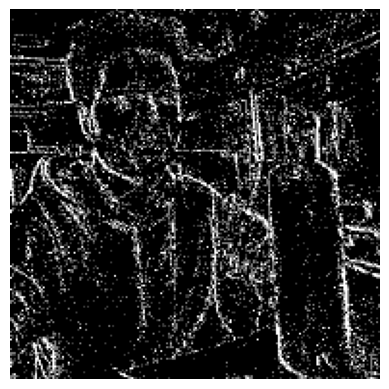

In [5]:
#model = modelbackup
# Define whether you want a greyscale image or not
grey = True
file = 'testInp.png'

if grey:
    #model = new
    img = Image.open(file).convert('L')
    colorBack = 0
    
else:
    model = modelbackup
    img = Image.open(file).convert('RGB')
    colorBack = (114, 114, 114)

# Resizes image
desired_size =  model.input_shape[1]
img = ImageOps.pad(img, (desired_size, desired_size), color=colorBack)
# arr = np.asarray(img, dtype=np.uint8).copy()  # create a writable copy
# arr[arr > 180] = 255
# arr[arr < 70] = 0
# img = Image.fromarray(arr, 'L')

# Convert to numpy array and scale to [0, 1] (the h5 files are prequantized)
img_array = np.asarray(img, dtype=np.float32) / 255.0

# If model expects batch dimension, add it:
if grey:
    img_array = np.expand_dims(img_array, axis=-1)  # shape: (192, 192, 1)
img_array = img_array[np.newaxis, ...] # shape: (1, 192, 192, 3)

print(img_array.shape, img_array.dtype, img_array.min(), img_array.max())
plt.imshow(img_array[0], cmap='gray' if grey else None)
plt.axis('off')
plt.show()

# 5. Create a new prediction

In [20]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_array)

In [21]:
# Print all raw outputs of the model in a readable format
pAll = model.predict(img_array)
pAll = [arr[0, :, :, :] for arr in pAll]
for idx, arr in enumerate(pAll):
    print(f"\n--- Raw Output for Model Output {idx} ---")
    print(np.array2string(arr, precision=3, suppress_small=True, max_line_width=120))


--- Raw Output for Model Output 0 ---
[[[  0.302  -0.236  -3.144  -2.953  -7.926]
  [  0.086  -0.399  -2.552  -3.354  -8.25 ]
  [  0.014  -0.275  -2.149  -3.212  -8.779]
  [  0.071   0.004  -1.829  -2.609  -8.972]
  [ -0.081  -0.651  -1.75   -2.941  -9.578]
  [  0.174  -0.927  -1.494  -2.866  -9.535]
  [  0.082  -0.796  -1.483  -2.745  -9.5  ]
  [  0.047  -0.617  -1.538  -2.536  -9.419]
  [ -0.289  -0.443  -1.899  -2.691  -9.684]
  [ -0.178  -0.156  -2.038  -2.799 -10.059]
  [  0.281  -0.175  -2.078  -3.085 -10.249]
  [  0.92    0.081  -2.926  -2.352  -8.672]]

 [[ -0.551   0.706  -3.532  -1.653  -8.098]
  [  0.059   0.528  -2.754  -2.149  -9.563]
  [  0.099   0.808  -1.821  -1.166  -8.875]
  [ -0.148   0.771  -1.456  -0.809  -8.896]
  [ -0.573   0.747  -1.274  -1.044  -9.615]
  [ -0.114   0.495  -0.65   -0.946 -10.275]
  [ -0.109   0.376  -0.852  -0.907  -9.627]
  [ -0.261   0.34   -0.959  -0.962  -9.032]
  [ -0.463  -0.077  -1.672  -1.667  -9.952]
  [ -0.297  -0.266  -2.225  -2.154 

# 6. Decode the prediction

In [22]:
pAll = model.predict(img_array)
pAll = [arr[0, :, :, :] for arr in pAll]
# Continue with your code (using p3, p4 as before)
print("p3 random element: ", pAll[0][0, 0, :])
all_boxes = []
all_boxes_flatten = []
prediction_sources = []
isCls = 1 if model.output_shape[0][-1] > 5 else 0

for i, p in enumerate(pAll):
    # Get the current stride
    stride = img_array.shape[1]/p.shape[0]
    print(stride)
    
    # Apply sigmoid to the first and last 2 channels (x, y, Pc, obj))
    if isCls:
        p[..., [0,1,4,5]] = expit(p[..., [0,1,4,5]])
    else:
        p[..., [0,1,4]] = expit(p[..., [0,1,4]])
    H, W = p.shape[:2]
    
    # Get the different grid position offsets
    gx, gy = np.meshgrid(np.arange(W), np.arange(H))
    
    
    # decode the center by adding the grid offsets then multiplying by the stride
    p[..., 0] = (p[..., 0] + gx) * stride
    p[..., 1] = (p[..., 1] + gy) * stride
    
    # decode the width and height by exponentiating and scaling
    p[..., [2,3]] = np.exp(p[..., [2,3]]) * model.input_shape[1]/2
    
    # put the boxes in an array and flatten them for different use cases
    all_boxes.append(p)
    flattened = p.reshape(-1, p.shape[-1])
    all_boxes_flatten.append(flattened)
    prediction_sources.extend([f"p{i+3}"] * flattened.shape[0]) 
    print(all_boxes_flatten[i].shape)

all_boxes_flatten = np.concatenate(all_boxes_flatten, axis=0)

p3 random element:  [ 0.30152133 -0.23626281 -3.1436238  -2.9527786  -7.9258766 ]
16.0
(144, 5)
32.0
(36, 5)


# 7. Test out prediction

## a. Check maximum and minimum of all elements

In [23]:
por = 1
# Calculate the maximum and minimum for each of the 6 elements
max_values = np.max(all_boxes[por], axis=(0, 1))
min_values = np.min(all_boxes[por], axis=(0, 1))
scores = all_boxes[por][..., 4] * all_boxes[por][..., 5] if isCls else all_boxes[por][..., 4]
max_values = np.append(max_values, np.max(scores))
min_values = np.append(min_values, np.min(scores))

element_names = ["x", "y", "height", "width", "Pc", "c1", "score"] if isCls else ["x", "y", "height", "width", "Pc", "score"]
# Print the results
for i in range(7 if isCls else 6):
    print(f"{element_names[i]}: Max = {max_values[i]}, Min = {min_values[i]}")

x: Max = 186.2953338623047, Min = 6.5797014236450195
y: Max = 172.85365295410156, Min = 8.264680862426758
height: Max = 79.4339828491211, Min = 3.3716697692871094
width: Max = 197.429931640625, Min = 9.380040168762207
Pc: Max = 0.9646619558334351, Min = 3.136333543807268e-05
score: Max = 0.9646619558334351, Min = 3.136333543807268e-05


## b. Output every bounding box

In [24]:
for i in range(all_boxes[por].shape[0]):  # Iterate over rows
    for j in range(all_boxes[por].shape[1]):  # Iterate over columns
        grid_cell_data = all_boxes[por][i, j]  # Shape: (6,)
        df = pd.DataFrame([grid_cell_data], columns=[f"{element_names[k]}" for k in range(0, 6 if isCls else 5)])
        print(f"Grid Cell ({i}, {j}): Score = {grid_cell_data[4]*grid_cell_data[5] if isCls else grid_cell_data[4]}")
        print(df)
        print("-" * 50)

Grid Cell (0, 0): Score = 3.625214958447032e-05
          x          y   height      width        Pc
0  8.608898  16.860622  3.37167  10.191174  0.000036
--------------------------------------------------
Grid Cell (0, 1): Score = 3.136333543807268e-05
           x          y     height      width        Pc
0  47.895496  24.001638  14.190248  25.711021  0.000031
--------------------------------------------------
Grid Cell (0, 2): Score = 8.526174497092143e-05
           x          y     height      width        Pc
0  74.977875  14.901448  19.011755  16.363836  0.000085
--------------------------------------------------
Grid Cell (0, 3): Score = 4.6374916564673185e-05
            x         y     height      width        Pc
0  111.544922  14.16503  17.831238  12.850792  0.000046
--------------------------------------------------
Grid Cell (0, 4): Score = 0.00012880541908089072
            x         y     height    width        Pc
0  141.493195  8.264681  14.948807  9.38004  0.000129
----

## c. View the top 5 bounding boxes by score

In [26]:
scores = all_boxes_flatten[:, 4] * all_boxes_flatten[:, 5] if isCls else all_boxes_flatten[:, 4]
top5_idxs = np.argsort(scores)[-5:][::-1]

# 2. Extract those boxes and their scores
top5_boxes  = all_boxes_flatten[top5_idxs]   # shape (5,6)
top5_scores = scores[top5_idxs]      # shape (5,)
top5_sources = [prediction_sources[idx] for idx in top5_idxs]  # Get the sources

# 3. (Optional) print them out
for rank, (box, score, source) in enumerate(zip(top5_boxes, top5_scores, top5_sources), start=1):
    x_center, y_center, w, h, obj = box
    print(f"{rank}: score={score:.3f}, source={source}, center=({x_center:.1f},{y_center:.1f}), "
          f"size=({w:.1f}*{h:.1f})")

1: score=0.965, source=p4, center=(71.8,112.1), size=(67.9*148.1)
2: score=0.934, source=p3, center=(70.2,117.0), size=(67.8*133.5)
3: score=0.904, source=p3, center=(71.6,106.0), size=(72.2*154.1)
4: score=0.776, source=p4, center=(60.4,117.4), size=(55.2*133.4)
5: score=0.585, source=p3, center=(60.4,118.8), size=(53.9*127.0)


## d. View the top bounding box on an image

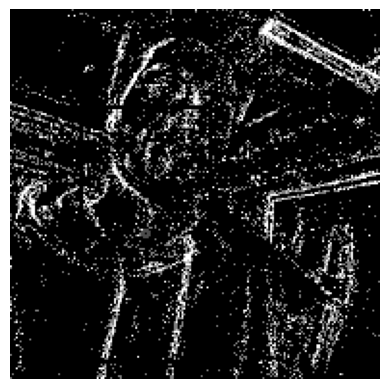

In [27]:
best_idx = top5_idxs[1]
best_box = all_boxes_flatten[best_idx] 

# --- Convert to corner coords ---
cx, cy, w, h = best_box[:4]
x1, y1 = cx - w/2, cy - h/2
x2, y2 = cx + w/2, cy + h/2

# --- Draw the box ---
img_with_box = img.copy()
draw = ImageDraw.Draw(img_with_box)
draw.rectangle([(int(x1), int(y1)), (int(x2), int(y2))],
               outline="black", width=2)
# Draw a red circle at (x1, y1)
circle_radius = 2  # Radius of the circle
draw.ellipse(
    [(int(cx) - circle_radius, int(cy) - circle_radius), 
     (int(cx) + circle_radius, int(cy) + circle_radius)],
    outline="red", width=2
)
plt.imshow(img_with_box, cmap='gray' if grey else None)
plt.axis('off')
plt.show()

## e. Perform non max suppression and print out remaining bounding boxes

In [28]:
# Define a threshold for filtering boxes
threshold = 0.5
valid_idxs = np.where(scores > threshold)[0]
filtered_boxes = all_boxes_flatten[valid_idxs]
filtered_scores = scores[valid_idxs]

# --- Convert to corner coordinates ---
x_centers, y_centers, widths, heights = filtered_boxes[:, 0], filtered_boxes[:, 1], filtered_boxes[:, 2], filtered_boxes[:, 3]
x1 = x_centers - widths / 2
y1 = y_centers - heights / 2
x2 = x_centers + widths / 2
y2 = y_centers + heights / 2

boxes = np.stack([x1, y1, x2, y2], axis=1)

# Perform non-maximum suppression
selected_indices = non_max_suppression(boxes, filtered_scores, iou_threshold=0.4)
final_boxes = boxes[selected_indices]
final_scores = filtered_scores[selected_indices]
final_sources = [prediction_sources[idx] for idx in valid_idxs[selected_indices]]

for rank, (box, score, source) in enumerate(zip(final_boxes, final_scores, final_sources), start=1):
    x1, y1, x2, y2 = box
    print(f"{rank}: score={score:.3f}, source={source}, top_corner=({x1:.1f},{y1:.1f}), "
          f"bottom_corner=({x2:.1f}*{y2:.1f})")

1: score=0.965, source=p4, top_corner=(37.8,38.0), bottom_corner=(105.7*186.1)
2: score=0.577, source=p4, top_corner=(91.7,43.4), bottom_corner=(145.7*179.5)


## f. Display all remaining bounding boxes

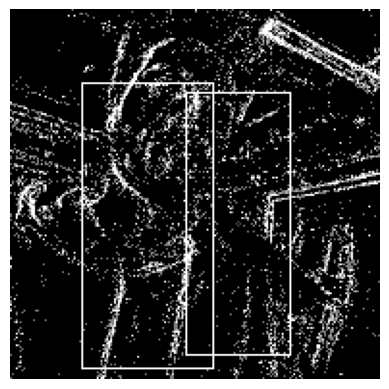

In [29]:
img_with_box = img.copy()
draw = ImageDraw.Draw(img_with_box)
circle_radius = 1

for box in final_boxes:
    cx = (box[0] + box[2]) / 2
    cy = (box[1] + box[3]) / 2
    x1, y1, x2, y2 = box
    draw.rectangle([(int(x1), int(y1)), (int(x2), int(y2))],
               outline="white", width=1)
    draw.ellipse(
        [(int(cx) - circle_radius, int(cy) - circle_radius), 
        (int(cx) + circle_radius, int(cy) + circle_radius)],
        outline="red", width=1
    )

plt.imshow(img_with_box, cmap='gray' if grey else None)
plt.axis('off')
plt.show()

# 8. Using the tfLite modesl instead of the .h5 (only real difference is that input image can remain 0-255)

5
Input details: [{'name': 'serving_default_input_edge:0', 'index': 0, 'shape': array([  1, 192, 192,   1]), 'shape_signature': array([ -1, 192, 192,   1]), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.003921568859368563, 0), 'quantization_parameters': {'scales': array([0.00392157], dtype=float32), 'zero_points': array([0]), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall:1', 'index': 302, 'shape': array([1, 6, 6, 5]), 'shape_signature': array([-1,  6,  6,  5]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'StatefulPartitionedCall:0', 'index': 283, 'shape': array([ 1, 12, 12,  5]), 'shape_signature': array([-1, 12, 12,  5]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32

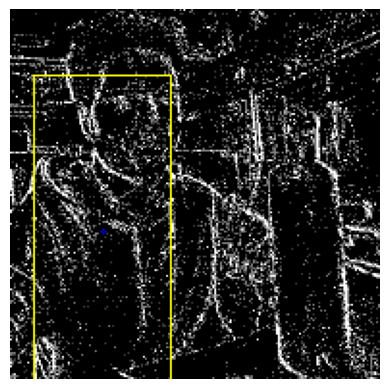

In [ ]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="models/experimental/trained/2_best_yolo_gs_CP_nohead1_noCls_lComb.tflite")
isCls = interpreter.get_output_details()[0]['shape'][-1] > 5
print(interpreter.get_output_details()[0]['shape'][-1])
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Print input and output details for debugging
print("Input details:", input_details)
print("Output details:", output_details)

# Preprocess the image (already in your notebook)
grey = True
file = 'testInp.png'

if grey:
    #model = new
    img_array = np.asarray(img)
    img = Image.open(file).convert('L')
    colorBack = 0
else:
    img = Image.open(file).convert('RGB')
    colorBack = (114, 114, 114)

desired_size =  192
img = ImageOps.pad(img, (desired_size, desired_size), color=colorBack)

# Convert to numpy array
img_array = np.asarray(img, dtype=np.uint8) #np.round(np.asarray(img, dtype=np.uint8)/255).astype(np.uint8)

# If model expects batch dimension, add it:
if grey:
    img_array = np.expand_dims(img_array, axis=-1)  # shape: (192, 192, 1)
img_array = img_array[np.newaxis, ...] # shape: (1, 192, 192, 3)

print(img_array.shape, img_array.dtype, img_array.min(), img_array.max())

# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], img_array)

# Run inference
interpreter.invoke()

# Retrieve the output tensors
outputs = [interpreter.get_tensor(output['index']) for output in output_details]

#print("p3 random element: ", p3[0, 0])
all_boxes = []
all_boxes_flatten = []
prediction_sources = []

for i, p in enumerate(outputs):
    stride = img_array.shape[1]/p.shape[1]
    print(p.shape)
    
    if isCls:
        p[..., [0,1,4,5]] = expit(p[..., [0,1,4,5]])
    else:
        p[..., [0,1,4]] = expit(p[..., [0,1,4]])
    H, W = p.shape[1:3]
    
    gx, gy = np.meshgrid(np.arange(W), np.arange(H))
    # decode centers
    p[..., 0] = (p[..., 0] + gx) * stride
    p[..., 1] = (p[..., 1] + gy) * stride
    # decode size
    
    p[..., [2,3]] = np.exp(p[..., [2,3]]) * input_details[0]['shape'][1]/2
    
    all_boxes.append(p)
    flattened = p.reshape(-1, p.shape[-1])
    all_boxes_flatten.append(flattened)
    prediction_sources.extend([f"p{i+3}"] * flattened.shape[0]) 
    print(all_boxes_flatten[i].shape)

all_boxes_flatten = np.concatenate(all_boxes_flatten, axis=0)

scores = all_boxes_flatten[:, 4] * all_boxes_flatten[:, 5] if isCls else all_boxes_flatten[:, 4]
top5_idxs = np.argsort(scores)[-5:][::-1]

# 2. Extract those boxes and their scores
top5_boxes  = all_boxes_flatten[top5_idxs]   # shape (5,6)
top5_scores = scores[top5_idxs]      # shape (5,)
top5_sources = [prediction_sources[idx] for idx in top5_idxs]  # Get the sources

# 3. (Optional) print them out
for rank, (box, score, source) in enumerate(zip(top5_boxes, top5_scores, top5_sources), start=1):
    #x_center, y_center, w, h, pred, obj = box
    x_center, y_center, w, h, obj = box
    print(f"{rank}: score={score:.3f}, source={source}, center=({x_center:.1f},{y_center:.1f}), "
          f"size=({w:.1f}*{h:.1f})")

best_idx = top5_idxs[3]
best_box = all_boxes_flatten[best_idx] 

# --- Convert to corner coords ---
threshold = 0.5
valid_idxs = np.where(scores > threshold)[0]
filtered_boxes = all_boxes_flatten[valid_idxs]
filtered_scores = scores[valid_idxs]

x_centers, y_centers, widths, heights = filtered_boxes[:, 0], filtered_boxes[:, 1], filtered_boxes[:, 2], filtered_boxes[:, 3]
x1 = x_centers - widths / 2
y1 = y_centers - heights / 2
x2 = x_centers + widths / 2
y2 = y_centers + heights / 2

boxes = np.stack([x1, y1, x2, y2], axis=1)

selected_indices = non_max_suppression(boxes, filtered_scores, 0.4)
final_boxes = boxes[selected_indices]
final_scores = filtered_scores[selected_indices]
final_sources = [prediction_sources[idx] for idx in valid_idxs[selected_indices]]

for rank, (box, score, source) in enumerate(zip(final_boxes, final_scores, final_sources), start=1):
    x1, y1, x2, y2 = box
    print(f"{rank}: score={score:.3f}, source={source}, top_corner=({x1:.1f},{y1:.1f}), "
          f"bottom_corner=({x2:.1f}*{y2:.1f})")

# --- Draw the box ---
img_with_box = img.convert("RGB")
draw = ImageDraw.Draw(img_with_box)
circle_radius = 1

for box in final_boxes:
    cx = (box[0] + box[2]) / 2
    cy = (box[1] + box[3]) / 2
    x1, y1, x2, y2 = box
    draw.rectangle([(int(x1), int(y1)), (int(x2), int(y2))],
               outline="yellow", width=1)
    draw.ellipse(
        [(int(cx) - circle_radius, int(cy) - circle_radius), 
        (int(cx) + circle_radius, int(cy) + circle_radius)],
        outline="blue", width=1
    )

plt.imshow(img_with_box)
plt.axis('off')
plt.show()
